In [35]:
%matplotlib inline

In [23]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from PIL import Image
import glob
import os

In [56]:
from topaz.utils.data.loader import load_image

# Cross validation and advanced threshold selection

In this section of the tutorial, we discuss cross validation of model hyperparameters and, later, a few techinques for selecting the score threshold for choosing predicted particles. This section assumes that you have topaz installed in a conda environment names "topaz", that you have already downloaded the demo data, and that the demo data has already been preprocessed. If not, please get the demo data and preprocess it as described in https://github.com/tbepler/topaz/blob/master/tutorial/01_quick_start_guide.ipynb and https://github.com/tbepler/topaz/blob/master/tutorial/02_walkthrough.ipynb

## Split the data into train and test splits

For this tutorial, we assume the data is split into train and test sets, but, in general, _this step is optional_.

We holdout 10 micrographs with their associated labeled particles to evaluate the model on data not present during training. This allows us to get a measure of the model's ability to generalize to new micrographs. Heldout data can also be used for _model selection_. That is, we can use performance on heldout data to help choose the best value of $\pi$ and other training parameters, such as the model architecture.

In [19]:
%%bash
source activate topaz

## the topaz command "train_test_split" can be used to split a set of micrographs with their corresponding
## labeled particle coordinates into train and test sets
## we hold out 10 randomly chosen micrographs as the test set
## the train and test particle tables and image list tables will be written
## to the same directory as the input particle table
topaz train_test_split -n 10 --image-dir data/EMPIAR-10025/processed/micrographs/ \
                       data/EMPIAR-10025/processed/particles.txt

# splitting 30 micrographs with 1500 labeled particles into 20 train and 10 test micrographs
# writing: data/EMPIAR-10025/processed/particles_train.txt
# writing: data/EMPIAR-10025/processed/particles_test.txt
# writing: data/EMPIAR-10025/processed/image_list_train.txt
# writing: data/EMPIAR-10025/processed/image_list_test.txt


## 5-fold cross validation of the expected number of particles and number of training iterations

We cross validate the expected number of particles per micrograph and the number of training epochs below. _Warning:_ this script trains 25 models and will take some time as a result. If you want, you can download precomputed cross validation results for the demo dataset [here](http://bergerlab-downloads.csail.mit.edu/topaz/cv-results.tar.gz) to proceed to analyzing the results without waiting for the models to train. Extract the files directly into the tutorials directory.

In [1]:
%%bash
# first, make sure we have the folders where we want to put the saved models
# store the saved models in saved_models/EMPIAR-10025
# we'll put the results of the cross validation runs in saved_models/EMPIAR-10025/cv
mkdir -p saved_models
mkdir -p saved_models/EMPIAR-10025
mkdir -p saved_models/EMPIAR-10025/cv

In [ ]:
%%bash
source activate topaz
topaz=$(which topaz) # unfortunate hack to get for loop to work here

# cross validation involves training models with different hyperparameter settings
# and evaluating these models on heldout data
# then, selecting the hyperparameters that gave best results on the heldout data
# to train a final model on the complete training set

# k-fold cross validation involves training k models for each setting
# where a different 1/kth of the data is held out for each round
# this gives a better estimate of the performance of models with that setting
# but requires training k models per setting

# here, we perform k-fold cross validation to select the pi parameter (through the
# expected number of particles per micrograph) and the number of training epochs


# on a cluster, this can be sped up by running each training command in parallel (recommended!)
# this is also easy to accelerate with multiple GPUs by running the training commands
# in parallel (e.g. one command per GPU!)
# the example here trains each model sequentially so it will be slow!

# we'll do 5-fold cross validation and try the following values of n
# using this bash script:


K=5
N_VALUES=(250 300 350 400 450 500)

# iterate possible values of N
for N in "${N_VALUES[@]}"; do
    # iterate each fold
    for ((fold=0;fold<K;fold++)); do
        # where to write results
        PATH="saved_models/EMPIAR-10025/cv/model_n${N}_fold${fold}_training.txt"
        echo ${PATH}
        # run the training command
        # the -k argument sets the number of folds
        # the --fold argument sets which fold to holdout for evaluation of the model
        ${topaz} train -n ${N} --num-workers=8 \
                       --train-images data/EMPIAR-10025/processed/image_list_train.txt \
                       --train-targets data/EMPIAR-10025/processed/particles_train.txt \
                       -k ${K} \
                       --fold ${fold} \
                       -o ${PATH}
    done
done

## Analyze the cross validation results

In [21]:
%%bash
# we have one training file per value of N per fold
ls saved_models/EMPIAR-10025/cv/

model_n250_fold0_training.txt
model_n250_fold1_training.txt
model_n250_fold2_training.txt
model_n250_fold3_training.txt
model_n250_fold4_training.txt
model_n300_fold0_training.txt
model_n300_fold1_training.txt
model_n300_fold2_training.txt
model_n300_fold3_training.txt
model_n300_fold4_training.txt
model_n350_fold0_training.txt
model_n350_fold1_training.txt
model_n350_fold2_training.txt
model_n350_fold3_training.txt
model_n350_fold4_training.txt
model_n400_fold0_training.txt
model_n400_fold1_training.txt
model_n400_fold2_training.txt
model_n400_fold3_training.txt
model_n400_fold4_training.txt
model_n450_fold0_training.txt
model_n450_fold1_training.txt
model_n450_fold2_training.txt
model_n450_fold3_training.txt
model_n450_fold4_training.txt
model_n500_fold0_training.txt
model_n500_fold1_training.txt
model_n500_fold2_training.txt
model_n500_fold3_training.txt
model_n500_fold4_training.txt


In [27]:
## we'll load these and store the performance on the held out data for
## each condition
tables = []
for n in [250, 300, 350, 400, 450, 500]:
    for fold in [0,1,2,3,4]:
        path = 'saved_models/EMPIAR-10025/cv/model_n{}_fold{}_training.txt'.format(n, fold)
        table = pd.read_csv(path, sep='\t')
        table['N'] = n
        table['fold'] = fold
        table = table.loc[table['split'] == 'test'] # only keep the validation results
        tables.append(table)
cv_results = pd.concat(tables, axis=0)
cv_results['auprc'] = cv_results['auprc'].astype(float)
cv_results.head()

,epoch,iter,split,loss,ge_penalty,precision,tpr,fpr,auprc,N,fold
5000,1,5001,test,0.034320,-,0.040919,0.094002,0.014501,0.061917,250,0
10001,2,10001,test,0.037891,-,0.062720,0.214466,0.021094,0.083872,250,0
15002,3,15001,test,0.040058,-,0.070757,0.251262,0.021718,0.086452,250,0
20003,4,20001,test,0.037802,-,0.068490,0.216862,0.019412,0.082383,250,0
25004,5,25001,test,0.048683,-,0.073186,0.294138,0.024516,0.082584,250,0


In [44]:
## calculate the mean AUPRC for each condition and each epoch
cv_results_mean = cv_results.groupby(['N', 'epoch']).mean().reset_index().drop('fold', axis=1)
cv_results_mean.head()

,N,epoch,iter,loss,precision,tpr,fpr,auprc
0,250,1,5001,0.036659,0.042756,0.122964,0.018283,0.067700
1,250,2,10001,0.036709,0.060158,0.189230,0.019539,0.082314
2,250,3,15001,0.036792,0.067854,0.201035,0.018217,0.081679
3,250,4,20001,0.039432,0.069421,0.223017,0.019825,0.082820
4,250,5,25001,0.044048,0.070694,0.247026,0.021299,0.077510


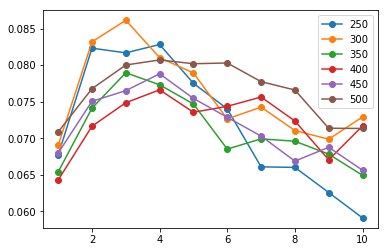

In [45]:
## plot the results
for N,result in cv_results_mean.groupby('N'):
    xx = result['epoch']
    yy = result['auprc']
    plt.plot(xx, yy, '-o', label=str(N))
plt.legend(loc='best')

In [46]:
## based on these results, we would conclude that we should train for 3 epochs with N=300
## take a look at table where for each N we report results of best epoch
cv_results_epoch = cv_results_mean.groupby('N').apply(lambda x: x.loc[x['auprc'].idxmax()]).reset_index(drop=True)
cv_results_epoch

,N,epoch,iter,loss,precision,tpr,fpr,auprc
0,250.0,4.0,20001.0,0.039432,0.069421,0.223017,0.019825,0.082820
1,300.0,3.0,15001.0,0.044224,0.067580,0.275414,0.024964,0.086137
2,350.0,3.0,15001.0,0.053200,0.063053,0.310390,0.030431,0.078956
3,400.0,4.0,20001.0,0.067710,0.064826,0.366210,0.034703,0.076616
4,450.0,4.0,20001.0,0.078893,0.063444,0.420088,0.040815,0.078813
5,500.0,4.0,20001.0,0.092463,0.062971,0.466964,0.045809,0.080707


## Train model with parameters selected above

In [47]:
%%bash
source activate topaz

# now, we train a model on the full training set
# using the parameters we selected above
# N = 300 and 3 epochs

topaz train -n 300 \
            --num-workers=8 \
            --num-epochs=3 \
            --train-images data/EMPIAR-10025/processed/image_list_train.txt \
            --train-targets data/EMPIAR-10025/processed/particles_train.txt \
            --test-images data/EMPIAR-10025/processed/image_list_test.txt \
            --test-targets data/EMPIAR-10025/processed/particles_test.txt \
            --save-prefix=saved_models/EMPIAR-10025/model \
            -o saved_models/EMPIAR-10025/model_training.txt

# Loading model: resnet8
# Model parameters: units=32, dropout=0.0, bn=on
# Receptive field: 71
# Using device=0 with cuda=True
# Loaded 20 training micrographs with 1000 labeled particles
# Loaded 10 test micrographs with 500 labeled particles
# source	split	p_observed	num_positive_regions	total_regions
# 0	train	0.00654	29000	4435200
# 0	test	0.00654	14500	2217600
# Specified expected number of particle per micrograph = 300.0
# With radius = 3
# Setting pi = 0.03923160173160173
# minibatch_size=256, epoch_size=5000, num_epochs=3
/data/cb/tbepler/workspace/topaz/topaz/methods.py:127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q_discrete = F.softmax(q_discrete) # dim=0 doesn't work for pytorch=0.2.0
# Done!


In [48]:
# examine the training results
training_results = pd.read_csv('saved_models/EMPIAR-10025/model_training.txt', sep='\t')
training_results.loc[training_results['split'] == 'test']

,epoch,iter,split,loss,ge_penalty,precision,tpr,fpr,auprc
5000,1,5001,test,0.040212,-,0.049726,0.188599,0.023721,0.0818742960691452
10001,2,10001,test,0.042068,-,0.065155,0.262653,0.024803,0.09573616832494736
15002,3,15001,test,0.042610,-,0.075171,0.291779,0.023626,0.0964217409491539


## Extract particle coordinates with this model

In [49]:
%%bash
source activate topaz

## extract particle coordinates using the model

topaz extract -r 7 -m saved_models/EMPIAR-10025/model_epoch3.sav \
              -o data/EMPIAR-10025/topaz/predicted_particles_all.txt \
              data/EMPIAR-10025/processed/micrographs/*.mrc

In [50]:
predicted_particles = pd.read_csv('data/EMPIAR-10025/topaz/predicted_particles_all.txt', sep='\t')
predicted_particles.head()

,image_name,x_coord,y_coord,score
0,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,190,308,2.72004
1,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,267,217,2.59311
2,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,257,352,2.40454
3,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,217,432,2.32638
4,14sep05c_c_00003gr_00014sq_00004hl_00004es_c,258,115,2.29941


## Analyze particle picks

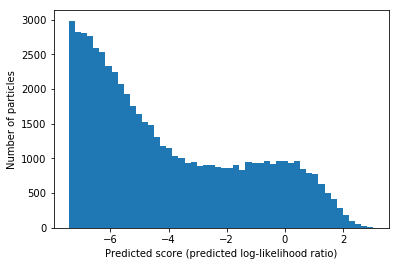

In [92]:
# plot the distribution of scores (predicted log-likelihood ratios)
_ = plt.hist(predicted_particles.score, bins=50)
plt.xlabel('Predicted score (predicted log-likelihood ratio)')
plt.ylabel('Number of particles')

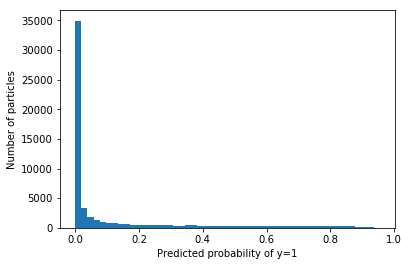

In [93]:
# plot predicted p(y=1|x) instead
proba = 1.0/(1.0 + np.exp(-predicted_particles.score))
_ = plt.hist(proba, bins=50)
plt.xlabel('Predicted probability of y=1')
plt.ylabel('Number of particles')

### Calculate the precision-recall curve to help choose the best threshold

In [70]:
%%bash
source activate topaz

## calculate the precision-recall curve for matching predicted particle coordinates
## to labeled particle coordinates on the test set micrographs

topaz precision_recall_curve -r 7 \
                             --predicted data/EMPIAR-10025/topaz/predicted_particles_all.txt \
                             --targets data/EMPIAR-10025/processed/particles_test.txt \
                             > saved_models/EMPIAR-10025/predicted_particles_prc.txt

/data/cb/tbepler/workspace/topaz/topaz/commands/precision_recall_curve.py:80: RuntimeWarning: invalid value encountered in true_divide
  f1 = 2*precision*recall/(precision + recall)


(-0.02, 1.02)

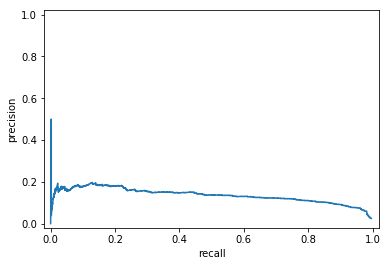

In [76]:
## load the precision-recall curve table and plot the curve
prc_table = pd.read_csv('saved_models/EMPIAR-10025/predicted_particles_prc.txt', sep='\t', comment='#')
plt.plot(prc_table['recall'], prc_table['precision'])
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim(-0.02, 1.02)
plt.xlim(-0.02, 1.02)

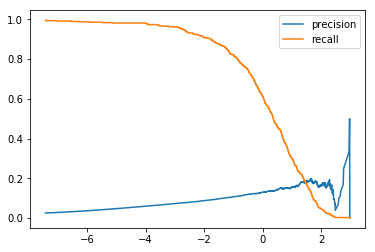

In [77]:
## plt the threshold vs. recall and threshold vs. precision
plt.plot(prc_table['threshold'], prc_table['precision'], label='precision')
plt.plot(prc_table['threshold'], prc_table['recall'], label='recall')
_ = plt.legend(loc='best')

Recall (at threshold $t$) is the fraction of true positives that are recovered at that threshold:
$$ recall(t) = \frac{TP(t)}{TP(t) + FN(t)} $$
Precision (at threshold $t$) is the fraction of predicted positives that are true positives:
$$ precision(t) = \frac{TP(t)}{TP(t) + FP(t)} $$

A good way to choose the threshold $t$ for selecting the particle set is based on a fixed recall level. For example, we could choose the threshold that gives 90%, 95%, or 99% recall to ensure that we recover as many positives as possible. The main thing to keep in mind when doing this, though, is that we could be introducing many false positives when selecting a high recall level. Another way to consider how well a model is performing, in this context, is to consider the precision of the model at fixed recall levels.

Below, we examine the thresholds that give various recall levels for this model and what the precision is at those thresholds.

In [78]:
def precision_and_threshold_at_recall(prc, levels):
    re = prc['recall'].values
    pr = prc['precision'].values
    th = prc['threshold'].values
    
    i = 0
    level = levels[i]
    prs = np.zeros_like(levels)
    ths = np.zeros_like(levels)
    
    for j in range(len(re)-1):
        if re[j] <= level and re[j+1] >= level:
            ## interpolate the precision and threshold
            a = (level - re[j])/(re[j+1] - re[j])
            b = (re[j+1] - level)/(re[j+1] - re[j])
            prs[i] = b*pr[j] + a*pr[j+1]
            ths[i] = b*th[j] + a*th[j+1]
            i += 1
            if i >= len(levels):
                break
            level = levels[i]
    return prs, ths

In [81]:
recall = [0.75, 0.9, 0.95, 0.99] # calculate the threshold and precision at these recall levels
precision,threshold = precision_and_threshold_at_recall(prc_table, recall)
table = pd.DataFrame({'recall': recall})
table['precision'] = precision
table['threshold'] = threshold
table

,recall,precision,threshold
0,0.75,0.119123,-0.512497
1,0.90,0.091056,-1.779800
2,0.95,0.076036,-2.738420
3,0.99,0.033496,-6.268090


In [82]:
## lets try the threshold giving 95% recall
t = threshold[2]
t

-2.7384200121169471

In [83]:
np.sum(predicted_particles.score >= t) # how many particles are predicted at this threshold

18936

### Visualize predictions

In [84]:
## load the labeled particles
labeled_particles = pd.read_csv('data/EMPIAR-10025/processed/particles.txt', sep='\t')

In [85]:
## load the micrographs for visualization
micrographs = {}
for path in glob.glob('data/EMPIAR-10025/processed/micrographs/*.mrc'):
    im = np.array(load_image(path), copy=False)
    name,_ = os.path.splitext(os.path.basename(path))
    micrographs[name] = im

In [86]:
## load the train/test split so we can look at results on test set only!
images_train = pd.read_csv('data/EMPIAR-10025/processed/image_list_train.txt', sep='\t')
images_train = images_train.image_name.unique()

images_test = pd.read_csv('data/EMPIAR-10025/processed/image_list_test.txt', sep='\t')
images_test = images_test.image_name.unique()
image_names = list(images_test) # micrograph names for the test set

14sep05c_c_00003gr_00014sq_00007hl_00004es_c


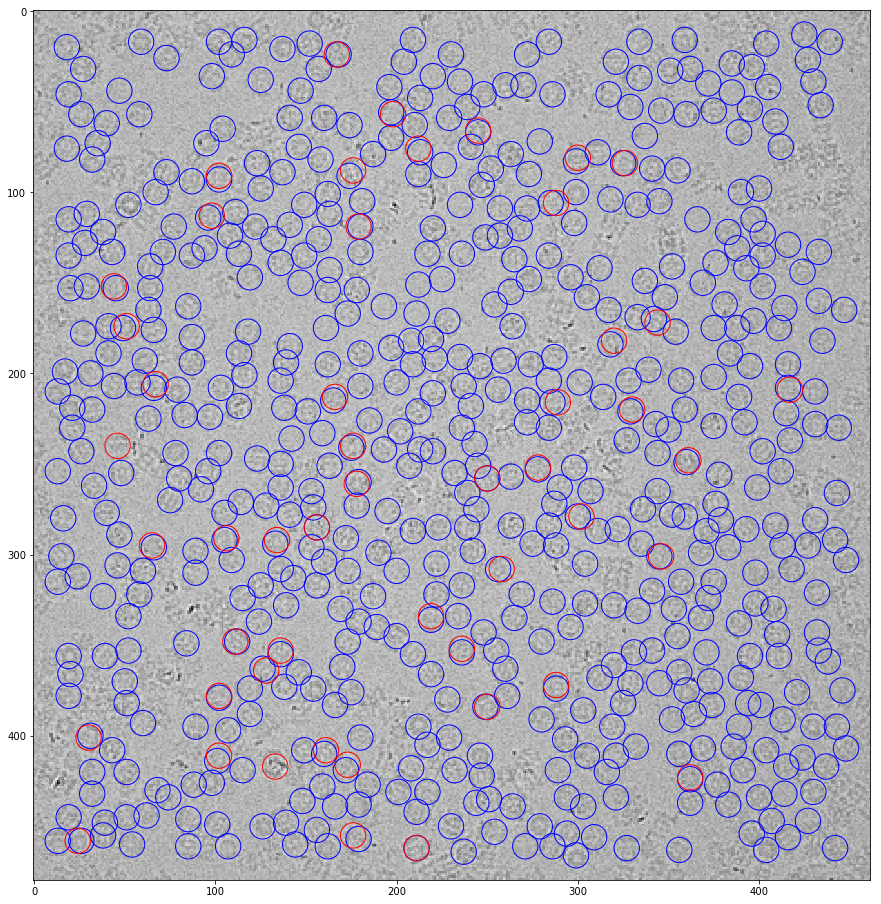

In [87]:
name = image_names[0]
print(name)
im = micrographs[name]
particles = predicted_particles.loc[predicted_particles['image_name'] == name]

particles = particles.loc[particles['score'] >= t]

_,ax = plt.subplots(figsize=(16,16))
ax.imshow(im, cmap='Greys_r')

radius = 7

# plot the predicted particles in blue
for x,y in zip(particles.x_coord, particles.y_coord):
    c = Circle((x,y),radius,fill=False,color='b')
    ax.add_patch(c)
    
# plot the (partial) ground truth particles in red
ground_truth = labeled_particles.loc[labeled_particles['image_name'] == name]
for x,y in zip(ground_truth.x_coord, ground_truth.y_coord):
    c = Circle((x,y),radius,fill=False,color='r')
    ax.add_patch(c)


14sep05c_c_00007gr_00013sq_00009hl_00004es_c


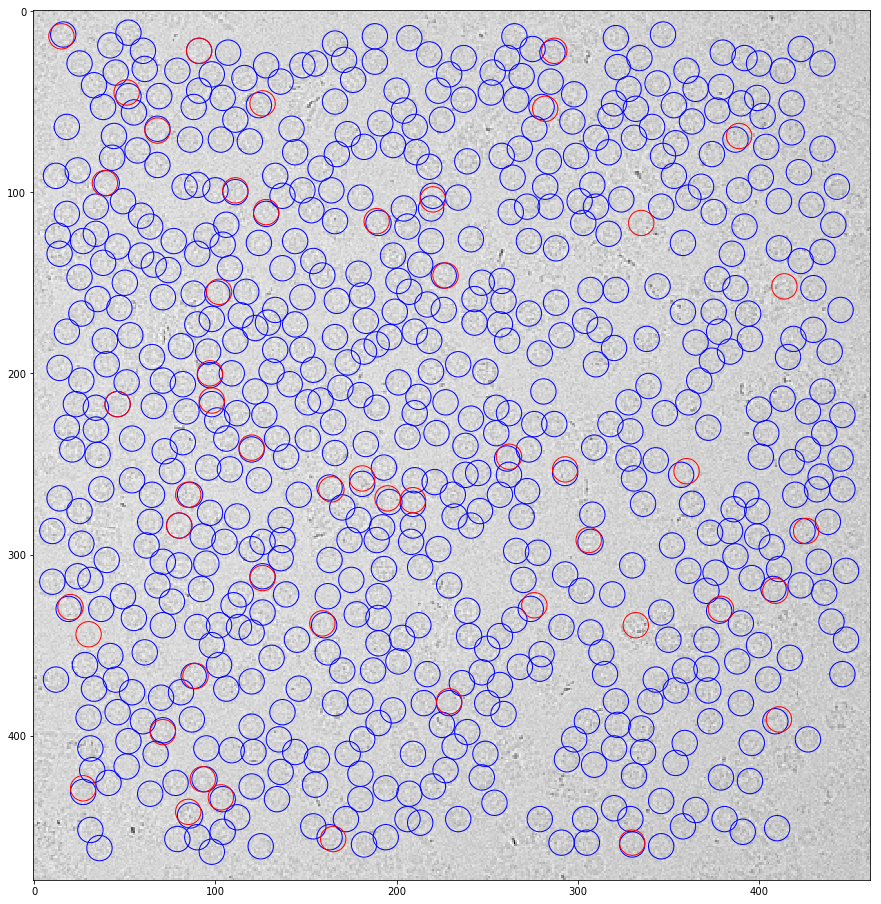

In [88]:
name = image_names[1]
print(name)
im = micrographs[name]
particles = predicted_particles.loc[predicted_particles['image_name'] == name]

particles = particles.loc[particles['score'] >= t]

_,ax = plt.subplots(figsize=(16,16))
ax.imshow(im, cmap='Greys_r')

radius = 7

# plot the predicted particles in blue
for x,y in zip(particles.x_coord, particles.y_coord):
    c = Circle((x,y),radius,fill=False,color='b')
    ax.add_patch(c)
    
# plot the (partial) ground truth particles in red
ground_truth = labeled_particles.loc[labeled_particles['image_name'] == name]
for x,y in zip(ground_truth.x_coord, ground_truth.y_coord):
    c = Circle((x,y),radius,fill=False,color='r')
    ax.add_patch(c)


14sep05c_c_00004gr_00032sq_00010hl_00003es_c


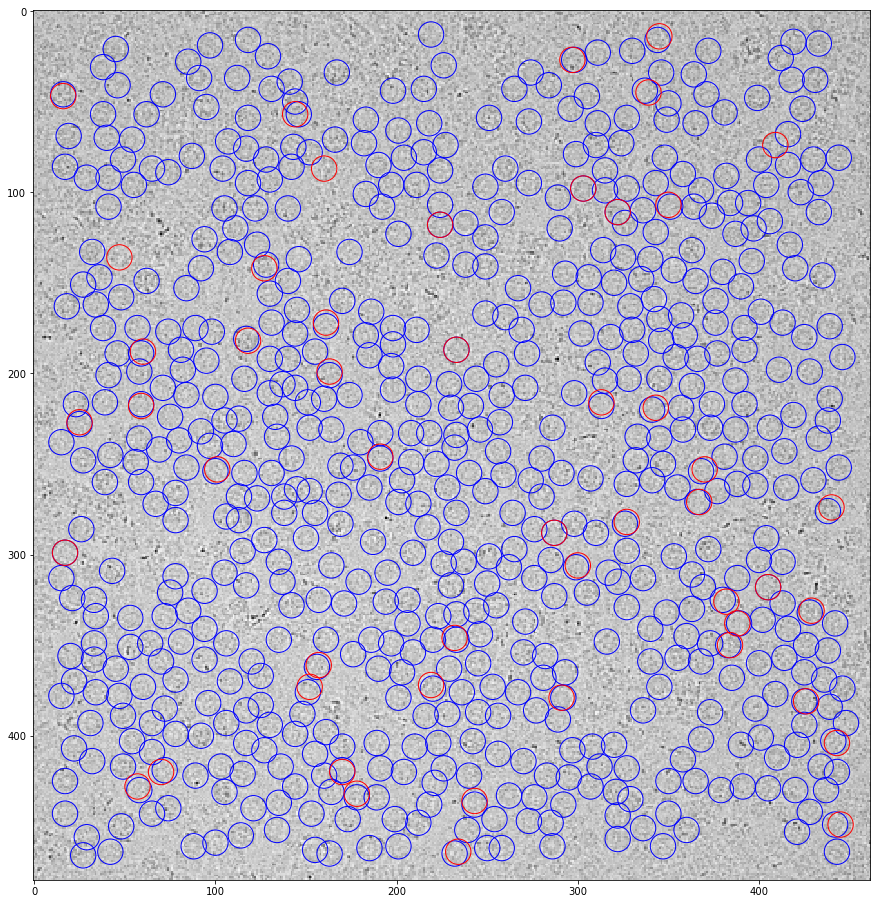

In [89]:
name = image_names[2]
print(name)
im = micrographs[name]
particles = predicted_particles.loc[predicted_particles['image_name'] == name]

particles = particles.loc[particles['score'] >= t]

_,ax = plt.subplots(figsize=(16,16))
ax.imshow(im, cmap='Greys_r')

radius = 7

# plot the predicted particles in blue
for x,y in zip(particles.x_coord, particles.y_coord):
    c = Circle((x,y),radius,fill=False,color='b')
    ax.add_patch(c)
    
# plot the (partial) ground truth particles in red
ground_truth = labeled_particles.loc[labeled_particles['image_name'] == name]
for x,y in zip(ground_truth.x_coord, ground_truth.y_coord):
    c = Circle((x,y),radius,fill=False,color='r')
    ax.add_patch(c)


As we can see, choosing the threshold to give high recall results in many more predicted particles. For this dataset, this appears to be good, but it does have the risk of introducing more false positives.

In [90]:
## visualize the top 100 predicted particles on the test set

n = 10
s = 31
panel = np.zeros((n*s, n*s), dtype=np.float32)

predicted_particles_test = predicted_particles.loc[predicted_particles.image_name.isin(images_test)]
predicted_particles_test = predicted_particles_test.sort_values('score', ascending=False)
for i in range(n):
    for j in range(n):
        k = i*n + j
        name = predicted_particles_test.iloc[k].image_name
        x_coord = predicted_particles_test.iloc[k].x_coord
        y_coord = predicted_particles_test.iloc[k].y_coord
        im = micrographs[name]
        
        xs = x_coord - s//2
        xe = xs + s
        ys = y_coord - s//2
        ye = ys + s
        
        pxs = j*s
        pxe = j*s+s
        pys = i*s
        pye = i*s+s
        
        if xs < 0:
            pxs -= xs
            xs = 0
        if xe > im.shape[1]:
            pxe -= xe - im.shape[1]
            xe = im.shape[1]
        if ys < 0:
            pys -= ys
            ys = 0
        if ye > im.shape[0]:
            pye -= ye - im.shape[0]
            ye = im.shape[0]
        
        panel[pys:pye,pxs:pxe] = im[ys:ye,xs:xe]

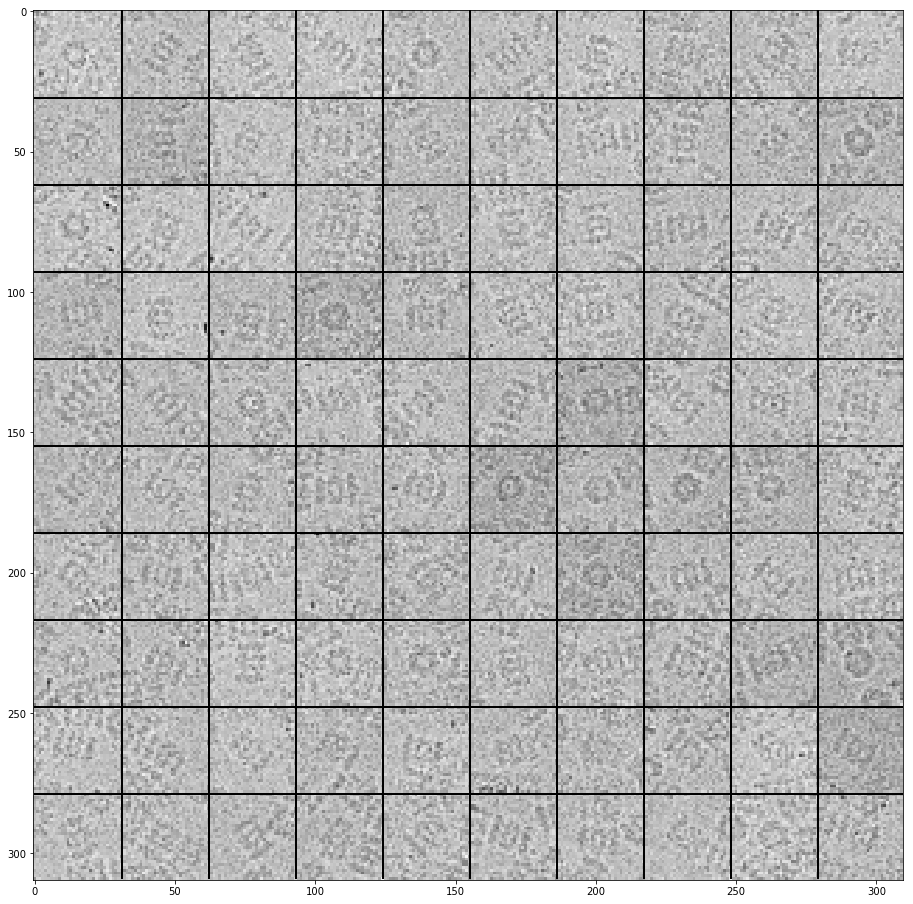

In [91]:
_,ax = plt.subplots(figsize=(16,16))
ax.imshow(panel, cmap='Greys_r')
for i in range(1,n):
    ax.plot([0,s*n-1],[i*s,i*s], 'k', linewidth=2)
    ax.plot([i*s,i*s],[0,s*n-1], 'k', linewidth=2)

## Conclusions

That's it! We used cross validation to choose the expected number of particles per micrograph for training ($N$) and how many iterations to train for. We then trained a model on the full training set using those parameters. Finally, we selected the score threshold based on examining the precision-recall curve on the test data and selecting the threshold to give 95% recall.